## Exam - January 2024
### **DS821**: News and Market Sentiment Analytics
Anna Olsen - anols22@student.sdu.dk

In [1]:
!pip install nltk spacy wordcloud vaderSentiment datasets seaborn scikit-learn
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 1.9 MB/s eta 0:00:07
     ---------------------------------------- 0.1/12.8 MB 1.3 MB/s eta 0:00:10
      --------------------------------------- 0.2/12.8 MB 1.5 MB/s eta 0:00:09
      --------------------------------------- 0.3/12.8 MB 1.5 MB/s eta 0:00:09
      --------------------------------------- 0.3/12.8 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.4/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.6/12.8 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.6/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.7/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.7/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.8/12.8 MB 1

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datasets import load_dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import nltk
import spacy
import pandas as pd
from collections import Counter
import seaborn as sns
import string
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from nltk.tag import pos_tag
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


c:\Users\Nicol\miniconda3\envs\annatest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

### Data loading
Load and prepare arXiv dataset

In [ ]:
# Get the current notebook file's path
notebook_path = os.path.abspath('')
script_directory = os.path.dirname(notebook_path)

# Check if "arXiv_subset.csv" and "count_arXiv.csv" exist in current working directory

csv_dataset = "arXiv_subset.csv"
csv_counter = "count_arXiv.csv"

def load_required_datasets(csv_dataset, csv_counter):

    required_files = [csv_dataset, csv_counter]

    if all([os.path.exists(x) for x in required_files]):
        print("Files 'arXiv_subset.csv' and 'count_arXiv.csv' already exist.")
        
        df = pd.read_csv(csv_dataset, dtype={'id': str})
        arxiv_count = pd.read_csv(csv_counter)

        print("Files are loaded as 'df' and 'arxiv_count'")

        return df, arxiv_count


    # If the files isn't in directory, load the dataset and create subset
    dataset = load_dataset("gfissore/arxiv-abstracts-2021", split='train')

    df = dataset.to_pandas()

    del dataset

    df['id'] = df['id'].astype(str)

    # print(df.head())

    # Extract digit 1-2 and digit 3-4 from 'id'
    date = df['id'].str.extract(r'(\d{2})(\d{2})')

    # Format the digits to datetime
    df['date'] = pd.to_datetime(
        date[0] + date[1], format='%y%m', errors='coerce')

    # Make columns for year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month_name()

    # Drop "date" column from df
    df = df.drop(columns=['date'])

    # Analyze trends over time in entire dataset
    arxiv_count = df.groupby('year')['id'].count()


    arxiv_count = arxiv_count.reset_index().rename(columns={'id': 'count'})

    # Save to csv
    arxiv_count.to_csv('count_arXiv.csv', columns=['year', 'count'], index=False)

    # Split categories into individual items and convert to tuples in the column
    df['categories'] = df['categories'].apply(
        lambda x: tuple(x[0].split() if len(x) > 0 else []))

    # Check if "cs.CL" is present in any category in the 'categories' column
    mask_CL = df['categories'].apply(lambda x: "cs.CL" in x)

    # Create a subset with rows containing "cs.CL"
    df_CL = df[mask_CL]

    print(f"Shape of 'Computation and Language' subset: {df_CL.shape}")

    # Filter rows containing "NLP" in the 'abstract' or 'title' column
    df_NLP = df[df['abstract'].str.contains(
        'NLP', case=True) | df['title'].str.contains('NLP', case=True)]

    print(f"Shape of 'NLP' subset: {df_NLP.shape}")

    # Combine the two dfs and remove duplicates based on 'id' columns
    df = pd.concat([df_CL, df_NLP]).drop_duplicates(subset=['id'])

    # # Reset the index of the combined df
    df = df.reset_index(drop=True)

    print(f"Shape of combined subset: {df.shape}")

    # Save the combined DataFrame to a new CSV file
    df.to_csv('arXiv_subset.csv', index=False)

    return df, arxiv_count


df, arxiv_count = load_required_datasets(csv_dataset, csv_counter)


Files 'arXiv_subset.csv' and 'count_arXiv.csv' already exist.
Files are loaded as 'df' and 'arxiv_count'


### Plot number of NLP papers vs. all arXiv papers

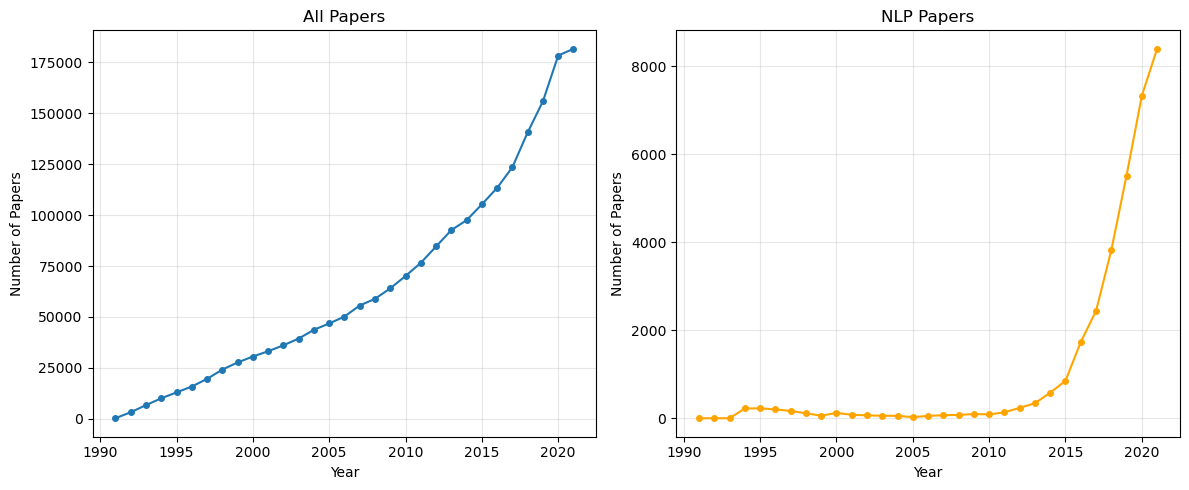

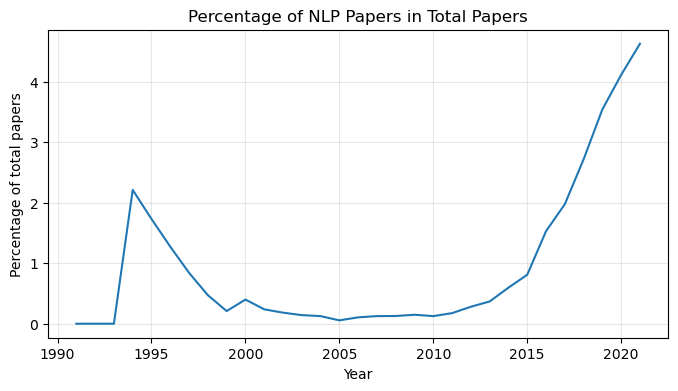

In [ ]:
# Analyze trends over time for NLP papers
NLP_count = df.groupby('year')['id'].count()

NLP_count = NLP_count.reset_index().rename(columns={'id': 'count'})

# Add empty rows for 1991, 1992, and 1993 
extra_rows = pd.DataFrame({'year': [1991, 1992, 1993], 'count': [0, 0, 0]})

NLP_count = pd.concat([NLP_count, extra_rows], ignore_index=True).sort_values(by='year').reset_index(drop=True)


# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plotting the trends for all abstracts in the second subplot
plt.subplot(1, 2, 1)
plt.plot(arxiv_count['year'], arxiv_count['count'], marker='o', markersize=4)
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('All Papers')
plt.grid(alpha=0.3)

# Plotting the trends for NLP abstracts in the first subplot
plt.subplot(1, 2, 2)
plt.plot(NLP_count['year'], NLP_count['count'], marker='o', markersize=4, color='orange')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('NLP Papers')
plt.grid(alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()


# Display the plot
plt.show()


NLP_relative = (NLP_count['count'] / arxiv_count['count']) * 100

plt.figure(figsize=(8, 4))
plt.plot(NLP_count['year'], NLP_relative)
plt.xlabel('Year')
plt.ylabel('Percentage of total papers')
plt.title('Percentage of NLP Papers in Total Papers')
plt.grid(alpha=0.3)
plt.show()

#### Create categories for years

In [ ]:
# Count the number of papers published in each year
year_counts = df['year'].value_counts()

#print(year_counts)

# Define bin edges
bins = [1994, 2000, 2010, 2017, 2020, 2021, 2022]

# Define bin labels
labels = ['1994-1999', '2000-2009', '2010-2016', '2017-2019', '2020', '2021']

# Create the 'time period' column
df['time period'] = pd.cut(df['year'], bins=bins, labels=labels, right=False).astype(str)


#print(df['time period'].value_counts())

#### Download NLTK packages and spaCy English model

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load NLTK packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annaolsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/annaolsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annaolsen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/annaolsen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Text Preprocessing

Tokenize text, change text to lowercase if True, remove stopwords, remove punctuation, lemmatize tokens and join words back into strings. 

In [ ]:
# Import stopwords
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer from NLTK
lemmatizer = WordNetLemmatizer()

# Function for preprocessing text
def preprocess_text(text, lowercase=False):

    # Tokenize text and convert to lowercase if True
    words = word_tokenize(text.lower()) if lowercase else word_tokenize(text)

    # Lemmatize each word -> remove punctuation and stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in string.punctuation and word not in stop_words]
    
    # Lemmatization with spaCy (not used)
    # doc = nlp(text)
    # words = [token.lemma_ for token in doc if token.text not in string.punctuation and token.text not in stop_words]


    # Join the processed words back into strings
    return ' '.join(words)


# Apply preprocessing to abstracts and create new columns in df

# abstract_processed is used for NER
df['abstract_processed'] = df['abstract'].apply(lambda x: preprocess_text(x, lowercase=False))

# abstract_lower is used for keywords and topic modeling 
df['abstract_lower'] = df['abstract'].apply(lambda x: preprocess_text(x, lowercase=True))

Print example of abstract after different preprocessing

In [ ]:
print(df['abstract_processed'][10000])
print(df['abstract_lower'][10000])

Motivated recent evidence pointing fragility high-performing span prediction model direct attention multiple choice reading comprehension In particular work introduces novel method improving answer selection long document weighted global normalization prediction portion document We show applying method span prediction model adapted answer selection help model performance long summary NarrativeQA challenging reading comprehension dataset answer selection task strongly improve task baseline performance +36.2 Mean Reciprocal Rank
motivated recent evidence pointing fragility high-performing span prediction model direct attention multiple choice reading comprehension particular work introduces novel method improving answer selection long document weighted global normalization prediction portion document show applying method span prediction model adapted answer selection help model performance long summary narrativeqa challenging reading comprehension dataset answer selection task strongly i

### Word Clouds

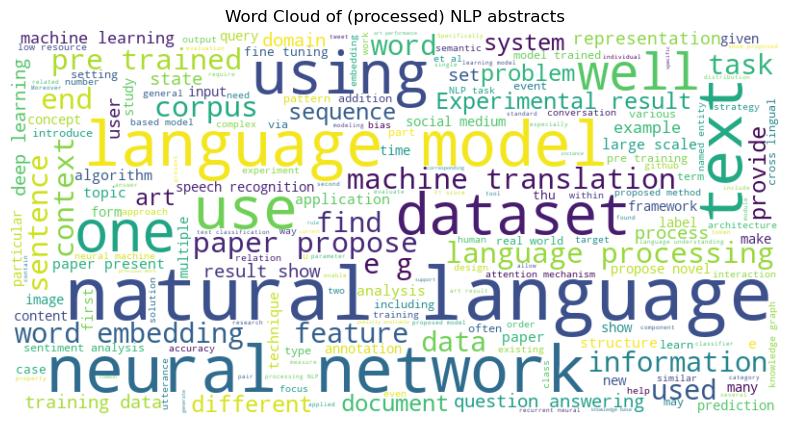

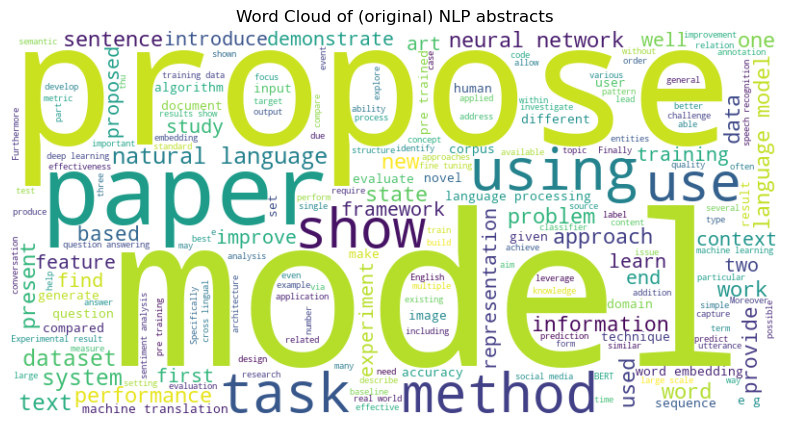

In [ ]:
# Word Cloud visualization - preprocessed abstracts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['abstract_processed']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of (processed) NLP abstracts')
plt.show()


# Word Cloud visualization - non-preprocessed abstracts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['abstract']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of (original) NLP abstracts')
plt.show()

#### Keywords

In [ ]:
# Combine all cleaned abstracts into a single string
all_abstracts_text = ' '.join(df['abstract_lower'])

# Tokenize the combined text
all_tokens = word_tokenize(all_abstracts_text)

# Examine the most common keywords or phrases in trending papers
all_keywords = all_tokens
top_keywords = pd.Series(all_keywords).value_counts().head(10)
print("Top 10 Keywords/Phrases:")
print(top_keywords)


# ---- Keyword extraction using TF-IDF ----
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['abstract_lower'])

# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Combine feature names and their corresponding scores
feature_scores = list(zip(feature_names, tfidf_scores))

# Sort features by TF-IDF scores in descending order
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Display the top N keywords and their TF-IDF scores
top_10_keywords = sorted_feature_scores[:10]
print("Top Keywords:")
for keyword, score in top_10_keywords:
    print(f"{keyword}: {score}")


Top 10 Keywords/Phrases:
model       61336
language    33501
task        27241
method      21385
data        20575
word        18687
approach    17750
system      17589
text        17500
paper       15924
Name: count, dtype: int64
Top Keywords:
model: 2122.2338091711817
language: 1532.1755667793634
task: 1293.4374597459484
word: 1181.512338452712
data: 1073.570744232513
text: 1059.1807794315766
method: 1042.923018539932
system: 1007.8923855683374
based: 994.9942965850199
approach: 901.7401759681069


## LDA Topic modeling

#### LDA - Grid Search

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Use a smaller subset of data to do Grid Search
lda_data = df['abstract'][:200]

# Create a pipeline with CountVectorizer and LDA
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('lda', LatentDirichletAllocation())
])

# Define the parameter grid
param_grid = {
    'vectorizer__min_df': [3, 4, 5, 6, 7],
    'vectorizer__max_df': [0.5, 0.6, 0.7, 0.8, 0.9],
    'lda__n_components': [8, 9, 10, 11, 12],
    'lda__learning_decay': [0.75, 0.8, 0.9]
}

# Use GridSearchCV to find the optimal parameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(lda_data)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Best Parameters: {'lda__learning_decay': 0.8, 'lda__n_components': 8, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 7}


#### LDA Topic Modeling

In [ ]:
# Define the parameters
n_topics = 8  # number of topics
words_per_topic = 7  # number of words per topic
learning_decay = 0.8  # learning decay
min_df = 7  # ignore terms that appear in less than 7 of the documents
max_df = 0.8  # ignore terms that appear in more than 80% of the documents


# Create a CountVectorizer with specified parameters
count_vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
X = count_vectorizer.fit_transform(df['abstract_lower'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, 
                                learning_decay=learning_decay, 
                                random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
for topic_id, topic in enumerate(lda.components_):
    top_words_id = topic.argsort()[:-words_per_topic - 1:-1]
    top_words = [feature_names[i] for i in top_words_id]
    print(f"Topic {topic_id + 1}: {', '.join(top_words)}")
    print("-----------" * 7)


Topic 1: model, generation, dialogue, learning, method, response, training
-----------------------------------------------------------------------------
Topic 2: text, document, data, based, information, system, method
-----------------------------------------------------------------------------
Topic 3: model, network, neural, attention, sentence, task, sequence
-----------------------------------------------------------------------------
Topic 4: model, task, language, training, data, question, learning
-----------------------------------------------------------------------------
Topic 5: language, graph, model, human, natural, knowledge, semantic
-----------------------------------------------------------------------------
Topic 6: social, language, sentiment, event, medium, analysis, detection
-----------------------------------------------------------------------------
Topic 7: system, speech, language, translation, model, recognition, data
----------------------------------------

#### Topic Modeling - Time periods

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define a function to perform LDA for each time period
def perform_lda(time_period_df, n_topics=5):
    count_vectorizer = CountVectorizer(min_df = 7, max_df = 0.8)
    X = count_vectorizer.fit_transform(time_period_df['abstract_lower'])

    # Create and fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    learning_decay=0.8,
                                    random_state=42)
    
    lda.fit(X)

    print(f"\nTopic Modeling for {time_period_df['time period'].iloc[0]}:")

    for topic_id, topic in enumerate(lda.components_):

        # Extract the top 5 words for the current topic
        feature_names = count_vectorizer.get_feature_names_out()
        top_words = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
        
        # Print the topic index and the top words
        print(f"Topic {topic_id + 1}: {', '.join(top_words)}")


# Group the df by 'time period' and apply the LDA model to each group
for time_period, time_period_df in df.groupby('time period'):
    perform_lda(time_period_df)



Topic Modeling for 1994-1999:
Topic 1: method, corpus, based, lexical, text
Topic 2: system, language, translation, speech, processing
Topic 3: discourse, structure, semantic, paper, theory
Topic 4: word, model, method, language, data
Topic 5: grammar, parsing, algorithm, parser, language

Topic Modeling for 2000-2009:
Topic 1: word, corpus, algorithm, method, system
Topic 2: model, data, question, answer, constraint
Topic 3: language, text, paper, linguistic, word
Topic 4: language, model, speech, system, information
Topic 5: grammar, based, algorithm, model, sentence

Topic Modeling for 2010-2016:
Topic 1: word, language, model, semantic, structure
Topic 2: language, system, text, data, paper
Topic 3: model, word, neural, network, task
Topic 4: topic, text, method, document, model
Topic 5: question, system, image, sentence, approach

Topic Modeling for 2017-2019:
Topic 1: model, task, network, neural, attention
Topic 2: question, system, language, data, knowledge
Topic 3: entity, mo

### Named Entity Recognition (NER)
#### Print entities

In [ ]:
# Named Entity Recognition (NER) using SpaCy
nlp = spacy.load('en_core_web_sm')

def print_entities(text):
    doc = nlp(text)

    for ent in doc.ents:
      print(ent.text, ent.label_)

ent_test = df['abstract'][:10]
ent_test = ent_test.apply(print_entities)

Arabic LANGUAGE
Arabic NORP
Recognition System ORG
CMU ORG
the Carnegie Mellon University ORG
CMU ORG
Sphinx FAC
OpenSource CMU Sphinx ORG
Arabic NORP
Arabic NORP
Automated
Speech Recognition System ORG
the Carnegie Mellon University ORG
Markov PERSON
Arabic NORP
Acoustic NORP
Arabic LANGUAGE
MacKenzie ORG
Chinese NORP
Chinese NORP
First ORDINAL
Fitts GPE
Hick PERSON
AAC ORG
AAC ORG
Chinese NORP
IM ORG
East Asian NORP
IM ORG
IM GPE
HCI ORG
NLP ORG
three CARDINAL
English LANGUAGE
corpora NORP
linear ORG
linear ORG
linear ORG
linear ORG
Robertson PERSON
Sparck Jones's ORG
Robertson ORG
1997 DATE
Karp-Rabin PERSON
Jensen PERSON
two CARDINAL
first ORDINAL
second ORDINAL
twelve CARDINAL


#### Extract entities - function

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Define function to extract entities from text
def extract_entities(text):
    doc = nlp(text)

    # Skip entities with these labels
    entities_filter = ['ORDINAL', 'CARDINAL', 'PERCENT', 'DATE']

    filtered_entities = [ent.text for ent in doc.ents if ent.label_ not in entities_filter]
    return filtered_entities


#### Apply entitiy function on abstracts

This takes a while to run so the output is saved to csv-files to make it easy to load and use later on - without running this again.

In [ ]:
entities_df_out = 'arXiv_subset_entities.json'
entities_count_df_out = 'entities.csv'

look_for_files = [entities_df_out, entities_count_df_out]

if all([os.path.exists(x) for x in look_for_files]):
    # Load files from directory if they exist
    df = pd.read_json(entities_df_out, orient='records', lines=True)
    entity_counts_df = pd.read_csv(entities_count_df_out)

else:
    # Apply extract_entities function on abstracts 
    df['entities'] = df['abstract'].apply(extract_entities)

    # Flatten the 'entities' column
    all_entities = [entity for sublist in df['entities'] for entity in sublist]

    # Count the occurrences of each entity
    entity_counts = Counter(all_entities)

    # Convert the Counter to a df for better visualization
    entity_counts_df = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['Count']).reset_index()
    entity_counts_df = entity_counts_df.rename(columns={'index': 'Entity'})

    # Sort the df by 'Count' in descending order (highest to lowest number)
    entity_counts_df = entity_counts_df.sort_values(by='Count', ascending=False)

    # Save the df with entity counts to a csv file
    entity_counts_df.to_csv(entities_count_df_out, index=False)

    # Save the entire df with all columns + entities column to csv
    df.to_json(entities_df_out, orient='records', lines=True)


# Print 20 most common entities
print(entity_counts_df.head(20))

         Entity  Count
0           NLP   5432
1       English   4926
2          BERT   3945
3   Transformer   1893
4       Chinese   1769
5           NMT   1643
6            QA   1503
7           NER   1258
8          BLEU   1208
9       Twitter   1166
10          RNN   1122
11          CNN    990
12       German    885
13    Wikipedia    881
14          ASR    877
15       Arabic    872
16     COVID-19    700
17      corpora    692
18           AI    662
19       French    644


#### Top entities for time periods

In [ ]:

# Create a function to perform entity extraction and counting for each time period
def process_entities(time_period_df):
    all_entities = []

    all_entities = [entity for sublist in time_period_df['entities'] for entity in sublist]

    # Count the occurrences of each entity
    entity_counts = Counter(all_entities)

    # Convert the Counter to a DataFrame for better visualization
    entity_counts_df = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['Count']).reset_index()
    entity_counts_df = entity_counts_df.rename(columns={'index': 'Entity'})

    # Sort the DataFrame by 'Count' in descending order
    entity_counts_df = entity_counts_df.sort_values(by='Count', ascending=False)

    # Display the DataFrame with entity counts
    print(f"Entity counts for {time_period_df['time period'].iloc[0]}:")
    print(entity_counts_df.head(10))
    print("\n")


# Group the DataFrame by 'time period' and apply the processing function
for time_period, time_period_df in df.groupby('time period'):
    process_entities(time_period_df)


Entity counts for 1994-1999:
       Entity  Count
42    English    142
17        NLP     63
41   Japanese     57
95     German     53
4        HPSG     48
63    Turkish     42
209    Korean     30
79     French     28
6     Spanish     28
11        LFG     28


Entity counts for 2000-2009:
       Entity  Count
18    English     86
17        NLP     39
54     French     32
277  Japanese     26
30        XML     26
19    corpora     21
177    German     21
10    Chinese     20
43    WordNet     20
42       Zipf     18


Entity counts for 2010-2016:
         Entity  Count
2       English    586
23          NLP    400
161     Twitter    256
268     Chinese    244
27       Arabic    208
937         RNN    191
1140        CNN    156
339   Wikipedia    151
1953        NMT    144
848        BLEU    127


Entity counts for 2017-2019:
       Entity  Count
14    English   1685
2         NLP   1479
2418     BERT    864
48        NMT    854
54    Chinese    745
11        RNN    599
167        QA   

### Create dictionary of entities + count

In [ ]:
ENT_DF_sorted = df.sort_values(by=['year', 'id'])

# Store entities in a dictionary with the count of each entity pr year, a total
# for all years combined, and the year the entity was introduced
entity_timeline = {}

# Iterate over all rows in sorted dataframe
for i, row in ENT_DF_sorted.iterrows():
  for entity in row['entities']:

    # If entity has been seen before just add to counter
    if entity in entity_timeline:
      if row['year'] not in entity_timeline[entity]['count']:
        # If first time seen this year, initialize year
        entity_timeline[entity]['count'][row['year']] = 1
      else:
        entity_timeline[entity]['count'][row['year']] += 1

      # Add to total counts
      entity_timeline[entity]['count']["00-total"] += 1
    else:
      # If first time seeing the entity, intialize its item
      entity_timeline[entity] = {
        'year': row['year'], 
        'count': {"00-total": 1, row['year']: 1}, 
        'title': row.get('title', None)}


{'year': 2018, 'count': {'00-total': 110, 2018: 1, 2019: 14, 2020: 47, 2021: 48}, 'title': 'Training Deeper Neural Machine Translation Models with Transparent\n  Attention'}
{'year': 2017, 'count': {'00-total': 1893, 2017: 6, 2018: 54, 2019: 349, 2020: 640, 2021: 844}, 'title': 'Attention Is All You Need'}
{'year': 2016, 'count': {'00-total': 12, 2016: 1, 2017: 1, 2019: 2, 2020: 4, 2021: 4}, 'title': 'Attention-based Memory Selection Recurrent Network for Language Modeling'}


In [ ]:
# Sort dict from highest values to lowest
sorted_entity_timeline = dict(sorted(entity_timeline.items(), key=lambda x: sum(x[1]['count'].values()), reverse=True))

# Save dictionary to json file
with open("entity_timeline.json", "w", encoding="utf-8") as json_file:
    json_file.write(json.dumps(sorted_entity_timeline, indent=4))

#### Plot trends in entities

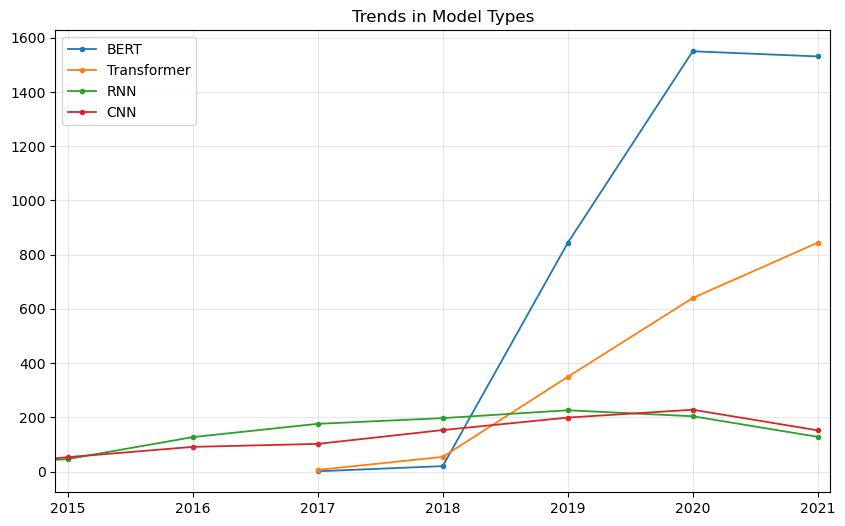

In [ ]:
# focus_entities = ["NLP", "BERT", "Transformer", "RNN", "CNN", "NMT", "QA", "NER",
                    #"RNN", "BLEU", "CNN", "ASR", "AI", "HPSG", "LFG", "Zipf", "Wordnet"]

focus_entities = ["BERT", "Transformer", "RNN", "CNN"]

# load json file with entities listed
with open("entity_timeline.json", "r", encoding="utf-8") as json_file:
    entity_timeline = json.loads(json_file.read())

plt.figure(figsize=(10, 6))

# plot entities from focus_entities list
for focus_entity in focus_entities:

    counts = entity_timeline[focus_entity]['count']
    total_count = counts['00-total']
    del counts['00-total']
    
    x = [int(x) for x in counts.keys()]
    y = list(counts.values())
    
    plt.plot(x, y, label=focus_entity, marker='o', markersize=3, linewidth=1.3)
    
    
plt.xticks(range(1994, 2022), rotation=0)
plt.xlim((2014.9, 2021.1))
plt.grid(alpha=0.3)
plt.title('Trends in Model Types')
plt.legend()
